# Numerical Stability of FENE-P Model

## Definition of the model

The FENE-P model (Finitely Extensible Nonlinear Elastic-Peterlin) is the most commonly used continuum viscoelastic model for in computatioanl fluid dynamics simulation of polymeric flows. In an incompressible polymeric flow (in the limit of dilute concentration), the governing equations are the continuity equation,

$$
\partial_iu_i =0,
$$

and the Navier-Stokes equation,

$$
\partial_tu_i+u_k\partial_ku_i=-\partial_ip+\frac{\beta}{Re}\partial_k\partial_ku_i+\frac{1-\beta}{Re}\partial_kT_{ik},
$$

supplemented by the polymer stress tensor

$$
T_{ij}=\cfrac{1}{Wi}\left(\cfrac{C_{ij}}{1-C_{kk}/L^2}-\delta_{ij}\right).
$$

The parameters $\beta$, $Wi$ and $L$ define the ratio of solvent viscosity to zero-shear viscosity of the polymer solution, the relaxation time of the polymer solution normalized by a specific flow time scale and the maximum length of a polymer molecule. The tensor $\delta_{ij}$ is the Kronecker tensor. Polymers are here represented as two beads, located at the extremities of a molecule, connected by a non-linear spring (the Peterlin function $f(c)=1/(1-c/L^2)$). In this model, an end-to-end vector $q_i$ defines each molecule The conformation tensor is the product of end-to-end vector components $C_{ij}=\left\langle q_iq_j\right\rangle$, phase-averaged over all local configurations. The transport equation for $C_{ij}$ writes:

$$
\partial_tC_{ij}=\underbrace{-u_k\partial_kC_{ij}}_{Adv_{ij}}+\underbrace{C_{ik}A_{kj}+A_{ik}C_{kj}}_{Str_{ij}}-T_{ij},
$$

where $A_{ij}=\partial_ju_i$ is the velocity gradient tensor. The three terms in the right hand side of the above equation are $Adv_{ij}$ the advection of $C_{ij}$, $Str_{ij}$ the stretching of polymers by the flow and $T_{ij}$ the polymer stress or the entropic term that tends to force polymers to return to their coiled configuation, the least energetic state.

## The Problem

The transport equation in the FENE-P model is devoid of diffusion and is consequently hyperbolic in nature. In complex flows, polymer drag reduction in turbulent flows, elasto-inertial turbulence, and elastic turbulence, the polymer stress organizes in thin sheets where polymers are significantly more stretched than their surroundings. The large gradients create numerical instabilities that often lead to the divergence of the solution, specifically $C_{kk}>L^2$ and/or one of the diagonal component lower that zero.

## Current Solutions

### Global Diffusion

The first solution is to add a diffusion term to the conformation tensor transport equation:

$$
\partial_tC_{ij}=\underbrace{-u_k\partial_kC_{ij}}_{Adv_{ij}}+\underbrace{C_{ik}A_{kj}+A_{ik}C_{kj}}_{Str_{ij}}-T_{ij}+\underbrace{\frac{1}{ReSc}\partial_k\partial_kC_{ij}}_{D_{ij}}
$$

The following short code shows how a second-order numerical scheme used to estimate the second derivative damps the maximum amplitude and thickens the width of a 1D sheet modeled after a simple function:

$$
u(x) = Ae^{-x^2}
$$


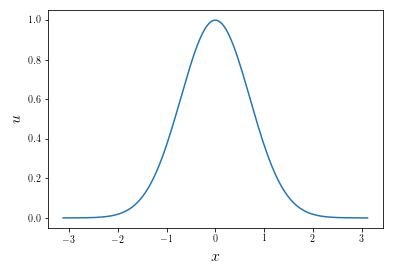

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
plt.rc('font', family='serif')
plt.rc('text', usetex=True)


A = 1
N = 129
L = 2*np.pi
def oneDsheet(A,N,L):
    x_cv = np.linspace(-L/2,L/2,N)
    x = (x_cv[1:] + x_cv[:-1])/2
    dx = L/(N-1)
    u = A*np.exp(-x**2)
    up = -2*A*x*np.exp(-x**2)
    upp = A*(-2*np.exp(-x**2)+4*x**2*np.exp(-x**2))
    return u,up,upp,x,dx

u,up,upp,x,dx = oneDsheet(A,N,L)

plt.plot(x,u)
plt.xlabel(r"$x$",fontdict=font)
plt.ylabel(r"$u$",fontdict=font)
plt.show()

Consider that we wish to solve the following equation:

$$
\partial_tu=\partial_x\partial_xu
$$

which, to a first order approximation in time, is

$$
u^{(n+1)}_i=u^{(n)}_i+\Delta t\partial_x\partial_xu^{(n)}.
$$

Setting the time step to $\Delta t=0.1$, the following graph shows the reduction of the peak and the lateral expansion of the sheet, caused by the sign reversal at the inflection points.

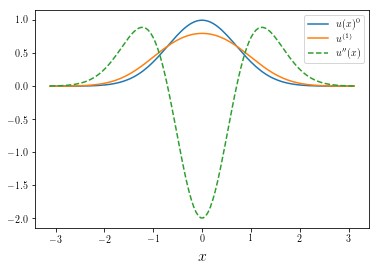

In [3]:
plt.plot(x,u,label="$u(x)^0$")
plt.plot(x,u+0.1*upp,label="$u^{(1)}$")
plt.plot(x,upp,'--',label="$u''(x)$")

plt.legend()
plt.xlabel(r"$x$",fontdict=font)
# plt.ylabel(r"$u$",fontdict=font)
plt.show()

The discretization introduces errors inherent to the numerical schemes used, specifically numerical dispersion and/or numerical dissipation. For the spatial second derivative, the simplest non-dissipative, but dispersive, finite difference scheme is 

$$
\partial_x\partial_xu_i^{(n)}= \frac{u_{i-1}^{(n)} - 2u_{i}^{(n)} + u_{i+1}^{(n)}}{\Delta x^2}+{\cal O}(\Delta x^2)
$$

To best assess the effects of discretization, it is best to decrease the resolution of our problem to 8 cells as follows:

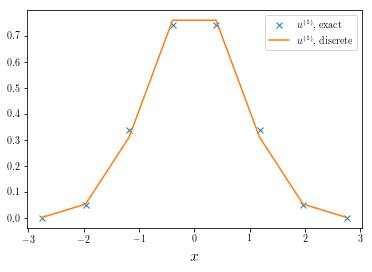

In [5]:
def d2x(u,dx):
    d2x = np.zeros_like(u)
    d2x[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    d2x[0] = u[-1] - 2*u[0] + u[1]
    d2x[-1] = u[-2] - 2*u[-1] + u[0]
    return d2x/dx**2

N = 9
u,up,upp,x,dx = oneDsheet(A,N,L)
ddxu = d2x(u,dx)
plt.plot(x,u+0.1*upp,'x',label="$u^{(1)}$, exact")
plt.plot(x,u+0.1*ddxu,label="$u^{(1)}$, discrete")

plt.legend()
plt.xlabel(r"$x$",fontdict=font)
# plt.ylabel(r"$u$",fontdict=font)
plt.show()

In [ ]:
The immediate effect 

In [6]:
dt = 0.001
i = 0 
N = 9
u9,up9,upp9,x9,dx9 = oneDsheet(A,N,L)
N = 129
u129,up129,upp129,x129,dx129 = oneDsheet(A,N,L) 
while i <= 999:
    u9old = np.copy(u9)
    rhs = d2x(u9,dx9)
    u9 += 0.5*dt*rhs
    rhs = d2x(u9,dx9)
    u9 = u9old + dt*rhs
    rhs = d2x(u129,dx129)
    u129old = np.copy(u129)
    u129 += 0.5*dt*rhs
    rhs = d2x(u129,dx129)
    u129 = u129old + dt*rhs
    i += 1
    

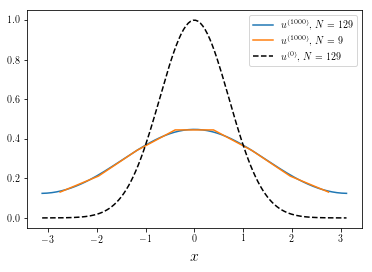

In [7]:
plt.plot(x129,u129,'-',label="$u^{(1000)}$, $N=129$")
plt.plot(x9,u9,label="$u^{(1000)}$, $N=9$")
N = 129
u,up,upp,x,dx = oneDsheet(A,N,L)
plt.plot(x,u,'k--',label="$u^{(0)}$, $N=129$")
plt.legend()
plt.xlabel(r"$x$",fontdict=font)
# plt.ylabel(r"$u$",fontdict=font)
plt.show()

In [22]:
def d1x_2(u,dx):
    d1x = np.zeros_like(u)
    d1x[1:-1] = 0.5*(u[2:] - u[:-2])/dx
    d1x[0] = 0.5*(u[1] - u[-1])/dx
    d1x[-1] = 0.5*(u[0] - u[-2])/dx
    return d1x
def d1x_3l(u,dx):
    d1x = np.zeros_like(u)
    d1x[2:-1] = u[:-3] - 6*u[1:-2] + 3*u[2:-1] + 2*u[3:]
    d1x[1] = u[-1] - 6*u[0] + 3*u[1] + 2*u[2]
    d1x[0] = u[-2] - 6*u[-1] + 3*u[0] + 2*u[1]
    d1x[-1] = u[-3] - 6*u[-2] + 3*u[-1] + 2*u[0]
    d1x /= 6*dx
    return d1x
    
    d1x[0] = 0.5*(u[1] - u[-1])/dx
    d1x[-1] = 0.5*(u[0] - u[-2])/dx
    return d1x

In [35]:
dt = 0.001
Nt = 1000
i = 0
N = 9
A=1
L = 4*np.pi
D = 0.00
c = L/(dt*Nt)
u9,up9,upp9,x9,dx9 = oneDsheet(A,N,L)
N = 129
u129,up129,upp129,x129,dx129 = oneDsheet(A,N,L) 
while i <= Nt-1:
    u9old = np.copy(u9)
    rhs = -c*d1x_2(u9,dx9)+D*d2x(u9,dx9)
    u9 += 0.5*dt*rhs
    rhs = -c*d1x_2(u9,dx9)+D*d2x(u9,dx9)
    u9 = u9old + dt*rhs
    
    u129old = np.copy(u129)
    rhs = -c*d1x_2(u129,dx129)+D*d2x(u129,dx129)
    u129 += 0.5*dt*rhs
    rhs = -c*d1x_2(u129,dx129)+D*d2x(u129,dx129)
    u129 = u129old + dt*rhs
    i += 1

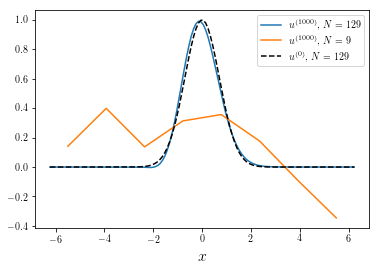

In [36]:
plt.plot(x129,u129,'-',label="$u^{(1000)}$, $N=129$")
plt.plot(x9,u9,label="$u^{(1000)}$, $N=9$")
N = 129
u,up,upp,x,dx = oneDsheet(A,N,L)
plt.plot(x,u,'k--',label="$u^{(0)}$, $N=129$")
plt.legend()
plt.xlabel(r"$x$",fontdict=font)
# plt.ylabel(r"$u$",fontdict=font)
plt.show()

In [ ]:

def tridag(a, b, c, r):
    """Solve linear system with tridiagonal coefficient matrix.
    a is the lower band, b is the diagonal, c is the upper band, and r
    is the right hand side. The solution is returned in u.
    [b1 c1 0 ...           ] [u1]   [r1] 
    [a1 b2 c2 0 ...        ] [ :]   [ :] 
    [ 0 a2 b3 c3 0 ...     ] [  ] = [  ] 
    [                      ] [  ]   [  ] 
    [ ...  0 an-2 bn-1 cn-1] [ :]   [ :] 
    [        ... 0 an-1 bn ] [un]   [rn] """ 

    n = len(b)
    tmp = np.zeros(n-1) # necessary temporary array 
    if b[0] == 0: 
        raise RuntimeError('System is effectively order N-1') 

    beta = b[0]
    u=np.zeros_like(r)
    u[0] = r[0] / beta 
    for i in range(1, n): # Decompose and forward substitution 
        tmp[i-1] = c[i-1] / beta 
        beta = b[i] - a[i-1] * tmp[i-1] 
        if beta == 0: 
            raise RuntimeError('Method failure')
        u[i] = (r[i] - a[i-1] * u[i-1]) / beta 

    for i in range(n-1, 0, -1): # Backward substitution 
        u[i-1] -= tmp[i-1] * u[i] 

    return u

########################################################
def cyclic(a, b, c, alpha, beta, r):
    """Solve linear system with tridiagonal coefficient matrix with
    corners alpha and beta (i.e. for a cyclic matrix).
    a is the lower band, b is the diagonal, c is the upper band, and r
    is the right hand side. The solution is returned in u.
    [b1 c1 0 ...       beta] [u1]   [r1] 
    [a1 b2 c2 0 ...        ] [ :]   [ :] 
    [ 0 a2 b3 c3 0 ...     ] [  ] = [  ] 
    [                      ] [  ]   [  ] 
    [ ...  0 an-2 bn-1 cn-1] [ :]   [ :] 
    [alpha   ... 0 an-1 bn ] [un]   [rn] """ 
#
    n=len(b)
    bb=np.zeros_like(b)
    u=np.zeros_like(b)
#
    gamma=-b[0]
    bb[0]=b[0]-gamma
    bb[-1]=b[-1]-alpha*beta/gamma
    for i in range(1,n-1):
        bb[i]=b[i]
    x=tridag(a,bb,c,r)
    u[0]=gamma
    u[n-1]=alpha
    for i in range(1,n-1):
        u[i]=0.
    z=tridag(a,bb,c,u)
    fact=(x[0]+beta*x[n-1]/gamma)/(1.+z[0]+beta*z[n-1]/gamma)
    for i in range(n):
        x[i]=x[i]-fact*z[i]
    return x

In [ ]:
A = 1
N = 33
L = 2*np.pi
x_cv = np.linspace(-L/2,L/2,N)
x = (x_cv[1:] + x_cv[:-1])/2
dx = L/(N-1)
def init_gauss(x,A):
    return A*np.exp(-x**2),-2*A*x*np.exp(-x**2),A*(-2*np.exp(-x**2)+4*x**2*np.exp(-x**2))
u, up , upp = init_gauss(x,A)
eps = 0*np.ones(N-1)
a = (2 - 3 * eps)
b = np.ones(N-1)*8
c = (2 + 3*eps)
rhs = np.zeros(N-1)
rhs[1:-1] = (1-eps[2:])*u[2:] + 2*eps[1:-1]*u[1:-1] - (1+eps[:-2])*u[:-2]
rhs[0] = (1-eps[1])*u[1] + 2*eps[0]*u[0] - (1+eps[-1])*u[-1]
rhs[-1] = (1-eps[0])*u[0] + 2*eps[-1]*u[-1] - (1+eps[-2])*u[-2]
rhs *= 6/dx

dup = cyclic(a,b,c,a[0],c[-1],rhs)


In [ ]:
plt.plot(x,up)
plt.plot(x,dup,'--')

In [ ]:
A = 1
N = 9
L = 2*np.pi
x_cv = np.linspace(-L/2,L/2,N)
x = (x_cv[1:] + x_cv[:-1])/2
dx = L/(N-1)
def init_gauss(x,A):
    return A*np.exp(-x**2),-2*A*x*np.exp(-x**2),A*(-2*np.exp(-x**2)+4*x**2*np.exp(-x**2))
u, up , upp = init_gauss(x,A)
a = np.ones(N-1)
b = np.ones(N-1)*4
c = np.ones(N-1)
rhs = np.zeros(N-1)
rhs[1:-1] = u[2:]  - u[:-2]
rhs[0] = u[1] - u[-1]
rhs[-1] = u[0] - u[-2]
rhs *= 3/dx

dup = cyclic(a,b,c,a[0],c[-1],rhs)

In [ ]:
plt.plot(x,up)
plt.plot(x,dup,'--')

In [ ]:
def taylor_green(Xu,Yu,Xv,Yv):
    u = np.zeros_like(Xu)
    v = np.zeros_like(Xv)
    u = np.cos(Xu)*np.sin(Yu)
    v = -np.sin(Xv)*np.cos(Yv)
    return u,v

def taylor_green_kolmogorov(Xu,Yu,Xv,Yv,a_tgv,k_tgv,a_K,k_K):
    u = np.zeros_like(Xu)
    v = np.zeros_like(Xv)
    u = a_tgv*np.cos(k_tgv*Xu)*np.sin(k_tgv*Yu)+a_K*np.sin(k_K*Yu)
    v = -a_tgv*np.sin(k_tgv*Xv)*np.cos(k_tgv*Yv)
    return u,v

In [ ]:
N = 33
L = 2*np.pi
x = np.linspace(-L/2,L/2,N)
y = np.linspace(-L/2,L/2,N)
dx = L/(N-1)
dy = L/(N-1)
x_u = np.copy(x[1:])
y_u = 0.5*(y[1:] + y[:-1])
x_v = 0.5*(x[1:] + x[:-1])
y_v = np.copy(y[1:])
x_p = 0.5*(x[1:] + x[:-1])
y_p = 0.5*(y[1:] + y[:-1])

Xu,Yu = np.meshgrid(x_u,y_u)
Xv,Yv = np.meshgrid(x_v,y_v)
Xp,Yp = np.meshgrid(x_p,y_p)

# u,v = taylor_green(Xu,Yu,Xv,Yv)
a_tgv = 1.
k_tgv = 1.
a_K = 4.
k_K = 1.
u,v = taylor_green_kolmogorov(Xu,Yu,Xv,Yv,a_tgv,k_tgv,a_K,k_K)
u_p = np.zeros_like(u)
v_p = np.zeros_like(v)
print(u.shape)
u_p[1:,:] = 0.5*(u[1:,:] + u[:-1,:])
u_p[0,:] = 0.5*(u[0,:] + u[-1,:])
v_p[:,1:] = 0.5*(v[:,1:] + v[:,:-1])
v_p[:,0] = 0.5*(v[:,0] + v[:,-1])


In [ ]:
plt.contourf(Xp,Yp,u_p)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [ ]:
plt.quiver(Xp,Yp,u_p,v_p,units='xy',scale=2.)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [ ]:
i_x = 0
i_y = 1
def advection_predictor(C,u,v):
    global dx,dy
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= v
    Dy = np.zeros((u.shape[0],u.shape[1],2,2))
    Dy[:-2,:,:,:] = (-7*F[:-2,:,:,:] + 8*F[1:-1,:,:,:] - F[2:,:,:,:])/(6*dx)
    Dy[-2,:,:,:] = (-7*F[-2,:,:,:] + 8*F[-1,:,:,:] - F[0,:,:,:])/(6*dx)
    Dy[-1,:,:,:] = (-7*F[-1,:,:,:] + 8*F[0,:,:,:] - F[1,:,:,:])/(6*dx)
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= u
    Dx = np.zeros((u.shape[0],u.shape[1],2,2))
    Dx[:,:-2,:,:] = (-7*F[:,:-2,:,:] + 8*F[:,1:-1,:,:] - F[:,2:,:,:])/(6*dy)
    Dx[:,-2,:,:] = (-7*F[:,-2,:,:] + 8*F[:,-1,:,:] - F[:,0,:,:])/(6*dy)
    Dx[:,-1,:,:] = (-7*F[:,-1,:,:] + 8*F[:,0,:,:] - F[:,1,:,:])/(6*dy)
    return -(Dx+Dy)
def advection_corrector(C,u,v):
    Dy = np.zeros((u.shape[0],u.shape[1],2,2))
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= v
    Dy[2:,:,:,:] = (7*F[2:,:,:,:] - 8*F[1:-1,:,:,:] + F[:-2,:,:,:])/(6*dx)
    Dy[1,:,:,:] = (7*F[1,:,:,:] - 8*F[0,:,:,:] + F[-1,:,:,:])/(6*dx)
    Dy[0,:,:,:] = (7*F[0,:,:,:] - 8*F[-1,:,:,:] + F[-2,:,:,:])/(6*dx)
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= u
    Dx = np.zeros((u.shape[0],u.shape[1],2,2))
    Dx[:,2:,:,:] = (7*F[:,2:,:,:] - 8*F[:,1:-1,:,:] + F[:,:-2,:,:])/(6*dy)
    Dx[:,1,:,:] = (7*F[:,1,:,:] - 8*F[:,0,:,:] + F[:,-1,:,:])/(6*dy)
    Dx[:,0,:,:] = (7*F[:,0,:,:] - 8*F[:,-1,:,:] + F[:,-2,:,:])/(6*dy)
    return -(Dx+Dy)
def velocity_gradient(u,v,up,vp):
    global dx,dy,i_x,i_y
    Aij = np.zeros((u.shape[0],u.shape[1],2,2))
    Aij[1:,:,i_y,i_y] = (v[1:,:] - v[:-1,:])/dy
    Aij[0,:,i_y,i_y] = (v[0,:] - v[-1,:])/dy
    Aij[1:-1,:,i_y,i_x] = 0.5*(up[2:,:] - up[:-2,:])/dy
    Aij[0,:,i_y,i_x] = 0.5*(up[1,:] - up[-1,:])/dy
    Aij[-1,:,i_y,i_x] = 0.5*(up[0,:] - up[-2,:])/dy
    Aij[:,1:-1,i_x,i_y] = 0.5*(vp[:,2:] - vp[:,:-2])/dx
    Aij[:,0,i_x,i_y] = 0.5*(vp[:,1] - vp[:,-1])/dx
    Aij[:,-1,i_x,i_y] = 0.5*(vp[:,0] - vp[:,-2])/dx
    Aij[:,1:,i_x,i_x] = (u[:,1:] - u[:,:-1])/dx
    Aij[:,0,i_x,i_x] = (u[:,0] - u[:,-1])/dx
    return Aij
def velocity_p_node(u,v):
    up = np.zeros_like(u)
    vp = np.zeros_like(v)
    up[1:,:] = 0.5*(u[1:,:] + u[:-1,:])
    up[0,:] = 0.5*(u[0,:] + u[-1,:])
    vp[:,1:] = 0.5*(v[:,1:] + v[:,:-1])
    vp[:,0] = 0.5*(v[:,0] + v[:,-1])
    return up,vp

def stretching(C,Aij):
    stretch = np.zeros_like(C)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                stretch[:,:,i,j] += C[:,:,i,k]*Aij[:,:,j,k]+C[:,:,k,j]*Aij[:,:,i,k]
    return stretch
def entropy(C,Wiinv,b):
    psi = 1 - (C[:,:,0,0] + C[:,:,1,1])/b
    entropy = np.zeros_like(C)
    for i in range (2):
        entropy[:,:,i,i] = -1.
    for i in range(2):
        for j in range(2):
            entropy[:,:,i,j] += C[:,:,i,j]/psi
    entropy *= -Wiinv
    return entropy
def init_C(N):
    C = np.zeros((N-1,N-1,2,2))
    C[:,:,0,0] = 1.
    C[:,:,1,1] = 1.
    return C
def diffusion(C):
    global dxsqinv,dysqinv,ReScinv
    diff = np.zeros_like(C)
    diff[1:-1,:,:,:] = (C[:-2,:,:,:] - 2*C[1:-1,:,:,:] - C[2:,:,:,:])*dysqinv
    diff[0,:,:,:] = (C[-1,:,:,:] - 2*C[0,:,:,:] - C[1,:,:,:])*dysqinv
    diff[-1,:,:,:] = (C[-2,:,:,:] - 2*C[-1,:,:,:] - C[0,:,:,:])*dysqinv
    diff[:,1:-1,:,:] = (C[:,:-2,:,:] - 2*C[:,1:-1,:,:] - C[:,:-2,:,:])*dxsqinv
    diff[:,0,:,:] = (C[:,-1,:,:] - 2*C[:,0,:,:] - C[:,1,:,:])*dxsqinv
    diff[:,-1,:,:] = (C[:,-2,:,:] - 2*C[:,-1,:,:] - C[:,0,:,:])*dxsqinv
    diff *= ReScinv
    return diff
def det_C(C):
    det = C[:,:,i_x,i_x]*C[:,:,i_y,i_y]-C[:,:,i_x,i_y]*C[:,:,i_y,i_x]
    return det,np.amin(det),np.amax(det)
def C_save(C,isave,N,L,Wi,ReScinv,t,t_t,t_detmin,t_detmax,t_Cmax):
    fname="C"+str(isave).zfill(4)+".h5"
    isave += 1
    print(fname)
    file = h5py.File(folder+fname,'w')
    Cset = file.create_dataset('C', data = C)
    t_tset = file.create_dataset('t_t', data = t_t)
    t_detminset = file.create_dataset('t_detmin', data = t_detmin)
    t_detmaxset = file.create_dataset('t_detmax', data = t_detmax)
    t_Cmaxset = file.create_dataset('t_Cmax', data = t_Cmax)
    Cset.attrs['N'] = N
    Cset.attrs['L'] = L
    Cset.attrs['Wi'] = Wi
    Cset.attrs['ReScinv'] = ReScinv
    Cset.attrs['t'] = t
    file.close()
    
    return

In [ ]:
import h5py
import os
folder = "C_2500_fields/"
try:
    os.mkdir(folder)
except OSError:
    print(folder+" folder already exists")

else:
    print(folder+" folder created")
restart = False
nsave = 10000
dt = 0.001
tsimu = 1000
Nt = int(tsimu/dt)
t = 0
Wi = 0.6
Wiinv = 1/Wi
L = 100
b = L**2
ReScinv = 1/2500
N = 65
if restart:
    irestart = 300
    fname = "C"+str(irestart).zfill(4)+".h5"
    file = h5py.File(folder+fname,'r')
    C = np.array(file['C'])
    t = file['C'].attrs['t']
    file.close()
    it = 0
    isave = irestart + 1
else:
    C = init_C(N)
    t = 0
    it = 0
    isave = 1
    print("initialization")
    
    
L = 2*np.pi
x = np.linspace(-L/2,L/2,N)
y = np.linspace(-L/2,L/2,N)
dx = L/(N-1)
dy = L/(N-1)
dxsqinv = 1/dx**2 
dysqinv = 1/dy**2
x_u = np.copy(x[1:])
y_u = 0.5*(y[1:] + y[:-1])
x_v = 0.5*(x[1:] + x[:-1])
y_v = np.copy(y[1:])
x_p = 0.5*(x[1:] + x[:-1])
y_p = 0.5*(y[1:] + y[:-1])

Xu,Yu = np.meshgrid(y_u,x_u)
Xv,Yv = np.meshgrid(y_v,x_v)
Xp,Yp = np.meshgrid(y_p,x_p)
u,v = taylor_green_kolmogorov(Xu,Yu,Xv,Yv,0.5,1,1,2)
up,vp = velocity_p_node(u,v)
Aij = velocity_gradient(u,v,up,vp)
it = 0
t_detmin = np.array([])
t_detmax = np.array([])
t_Cmax = np.array([])
t_t = np.array([])
det,detmin,detmax = det_C(C)
while (t < tsimu) and (detmin > -10) :
    C0 = np.copy(C)
    # step 1 
#     advection_term = advection(C,up,vp)
    advection_term = advection_predictor(C,up,vp)
    stretch_term = stretching(C,Aij)
    entropy_term = entropy(C,Wiinv,b)
    diffusion_term = diffusion(C)
    C += dt*(advection_term + stretch_term + entropy_term + diffusion_term)
    #step 2
    advection_term = advection_corrector(C,up,vp)
    stretch_term = stretching(C,Aij)
    entropy_term = entropy(C,Wiinv,b)
    diffusion_term = diffusion(C)
    C = 0.5*(C0 + C + dt*(advection_term + stretch_term + entropy_term + diffusion_term))
    det,detmin,detmax = det_C(C)
    t += dt
    
    t_t = np.append(t_t,t)
    t_detmin = np.append(t_detmin,detmin)
    t_detmax = np.append(t_detmax,detmax)
    t_Cmax = np.append(t_Cmax,np.amax(C[:,:,i_x,i_x]+C[:,:,i_y,i_y])/L**2*100)
    it += 1
    if (it%nsave == 0):
        print(t,detmin,detmax,np.amax(C[:,:,i_x,i_x]+C[:,:,i_y,i_y])/L**2*100)
        
        C_save(C,isave,N,L,Wi,ReScinv,t,t_t,t_detmin,t_detmax,t_Cmax)
        isave += 1
        clear_output(wait=True)

print(it,t,detmin,detmax,np.amax(C[:,:,i_x,i_x]+C[:,:,i_y,i_y])/L**2*100)
    

In [ ]:
n = 4
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
lev = np.linspace(0,20,50)
plt.contourf(Xp,Yp,(C[:,:,i_x,i_x]+C[:,:,i_y,i_y])/L**2*100,levels = lev)
plt.colorbar()
plt.quiver(Xp[::n,::n],Yp[::n,::n],up[::n,::n],vp[::n,::n],units='xy',scale=2.,color='white')
plt.xlabel(r"$x$", fontdict = font)
plt.ylabel(r"$y$", fontdict = font)
plt.show()

In [ ]:
n = 4
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
lev = np.linspace(-0.1,0,50)
plt.contourf(Xp,Yp,C[:,:,i_x,i_x]*C[:,:,i_y,i_y]-C[:,:,i_x,i_y]**2,levels = lev)
plt.colorbar()
plt.quiver(Xp[::n,::n],Yp[::n,::n],up[::n,::n],vp[::n,::n],units='xy',scale=2.,color='white')
plt.xlabel(r"$x$", fontdict = font)
plt.ylabel(r"$\det(C_{ij})$", fontdict = font)
plt.show()

In [ ]:
plt.plot(t_t,t_detmin)
plt.xlabel(r"$t$", fontdict = font)
plt.ylabel(r"$\min[\det(C_{ij})]$", fontdict = font)
plt.show()

In [ ]:
plt.plot(t_t,t_Cmax)
plt.xlabel(r"$t$", fontdict = font)
plt.ylabel(r"$\max(C_{ij})$", fontdict = font)
plt.show()

In [ ]:
isave = 1
fname="C"+str(isave).zfill(4)+".h5"
fname

In [ ]:
C = np.zeros((N-1,N-1,2,2))
C[:,:,0,0] = 1.
C[:,:,1,1] = 1.

def prep_huc_x(u):
    b = 8*np.ones_like(u)
    eps = np.sign(u)
    a = (2 - 3 * eps)
    b *= 8
    c = (2 + 3*eps)
    return a,b,c,eps
def adv_huc_x(C,u,a,b,c,eps):
    global dx
    rhs = np.zeros_like(u)
    rhs[1:-1,:] = (1-eps[1:-1])*C[2:,:] \
    + 2*eps[1:-1]*C[1:-1,:]  \
    - (1+eps[1:-1])*C[:-2,:]
    rhs[0,:] = (1-eps[0])*C[1,:]  \
    + 2*eps[0]*C[0,:] \
    - (1+eps[0])*C[-1,:]
    rhs[-1,:] = (1-eps[-1])*C[0,:] \
    + 2*eps[-1]*C[-1,:] \
    - (1+eps[-1])*C[-2,:]
    rhs *= 6/dx
    dxC = np.zeros_like(u)
    for j in range(u.shape[1]):
        dxC[:,j] = cyclic(a[:,j],b[:,j],c[:,j],a[0,j],c[-1,j],rhs[:,j])
    return -u*dxC
def advection_predictor(C,u,v):
    global dx,dy
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= u
    Dx = np.zeros((u.shape[0],u.shape[1],2,2))
    Dx[:-2,:,:,:] = (-7*F[:-2,:,:,:] + 8*F[1:-1,:,:,:] - F[2:,:,:,:])/(6*dx)
    Dx[-2,:,:,:] = (-7*F[-2,:,:,:] + 8*F[-1,:,:,:] - F[0,:,:,:])/(6*dx)
    Dx[-1,:,:,:] = (-7*F[-1,:,:,:] + 8*F[0,:,:,:] - F[1,:,:,:])/(6*dx)
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= v
    Dy = np.zeros((u.shape[0],u.shape[1],2,2))
    Dy[:,:-2,:,:] = (-7*F[:,:-2,:,:] + 8*F[:,1:-1,:,:] - F[:,2:,:,:])/(6*dy)
    Dy[:,-2,:,:] = (-7*F[:,-2,:,:] + 8*F[:,-1,:,:] - F[:,0,:,:])/(6*dy)
    Dy[:,-1,:,:] = (-7*F[:,-1,:,:] + 8*F[:,0,:,:] - F[:,1,:,:])/(6*dy)
    return -(Dx+Dy)
def advection_corrector(C,u,v):
    Dx = np.zeros((u.shape[0],u.shape[1],2,2))
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= u
    Dx[2:,:,:,:] = (7*F[2:,:,:,:] - 8*F[1:-1,:,:,:] + F[:-2,:,:,:])/(6*dx)
    Dx[1,:,:,:] = (7*F[1,:,:,:] - 8*F[0,:,:,:] + F[-1,:,:,:])/(6*dx)
    Dx[0,:,:,:] = (7*F[0,:,:,:] - 8*F[-1,:,:,:] + F[-2,:,:,:])/(6*dx)
    Dy = np.zeros((u.shape[0],u.shape[1],2,2))
    F = np.copy(C)
    for i in range(2):
        for j in range(2):
            F[:,:,i,j] *= v
    Dy[:,2:,:,:] = (7*F[:,2:,:,:] - 8*F[:,1:-1,:,:] + F[:,:-2,:,:])/(6*dy)
    Dy[:,1,:,:] = (7*F[:,1,:,:] - 8*F[:,0,:,:] + F[:,-1,:,:])/(6*dy)
    Dy[:,0,:,:] = (7*F[:,0,:,:] - 8*F[:,-1,:,:] + F[:,-2,:,:])/(6*dy)
    return -(Dx+Dy)
def prep_huc_y(v):
    b = 8*np.ones_like(v)
    eps = np.sign(v)
    a = (2 - 3 * eps)
    b *= 8
    c = (2 + 3*eps)
    return a,b,c,eps
def adv_huc_y(C,v,a,b,c,eps):
    global dy
    rhs = np.zeros_like(v)
    rhs[1:-1,:] = (1-eps[1:-1])*C[2:,:] \
    + 2*eps[1:-1]*C[1:-1,:]  \
    - (1+eps[1:-1])*C[:-2,:]
    rhs[0,:] = (1-eps[0])*C[1,:]  \
    + 2*eps[0]*C[0,:] \
    - (1+eps[0])*C[-1,:]
    rhs[-1,:] = (1-eps[-1])*C[0,:] \
    + 2*eps[-1]*C[-1,:] \
    - (1+eps[-1])*C[-2,:]
    rhs *= 6/dx
    dyC = np.zeros_like(v)
    for i in range(v.shape[0]):
        dyC[i,:] = cyclic(a[i,:],b[i,:],c[i,:],a[i,0],c[i,-1],rhs[i,:])
    return -v*dyC    
def advection(C,up,vp):
    advection = np.zeros_like(C)
    ax,bx,cx,epsx = prep_huc_x(up)
    ay,by,cy,epsy = prep_huc_y(vp)
    for i in range(2):
        for j in range(2):
            advection[:,:,i,j] = adv_huc_x(C[:,:,i,j],up,ax,bx,cx,epsx) \
            +adv_huc_y(C[:,:,i,j],vp,ay,by,cy,epsy)
    return advection
def velocity_gradient(u,v,up,vp):
    global dx,dy
    Aij = np.zeros((u.shape[0],u.shape[1],2,2))
    Aij[1:,:,0,0] = (u[1:,:] - u[:-1,:])/dx
    Aij[0,:,0,0] = (u[0,:] - u[-1,:])/dx
    Aij[1:-1,:,1,0] = 0.5*(vp[2:,:] - vp[:-2,:])/dx
    Aij[0,:,1,0] = 0.5*(vp[1,:] - vp[-1,:])/dx
    Aij[-1,:,1,0] = 0.5*(vp[0,:] - vp[-2,:])/dx
    Aij[:,1:-1,0,1] = 0.5*(up[:,2:] - up[:,:-2])/dx
    Aij[:,0,0,1] = 0.5*(up[:,1] - up[:,-1])/dx
    Aij[:,-1,0,1] = 0.5*(up[:,0] - up[:,-2])/dx
    Aij[:,1:,1,1] = (v[:,1:] - v[:,:-1])/dy
    Aij[:,0,1,1] = (v[:,0] - v[:,-1])/dy
    return Aij
def velocity_p_node(u,v):
    up = np.zeros_like(u)
    vp = np.zeros_like(v)
    up[1:,:] = 0.5*(u[1:,:] + u[:-1,:])
    up[0,:] = 0.5*(u[0,:] + u[-1,:])
    vp[:,1:] = 0.5*(v[:,1:] + v[:,:-1])
    vp[:,0] = 0.5*(v[:,0] + v[:,-1])
    return up,vp

def stretching(C,Aij):
    stretch = np.zeros_like(C)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                stretch[:,:,i,j] += C[:,:,i,k]*Aij[:,:,j,k]+C[:,:,k,j]*Aij[:,:,i,k]
    return stretch
def entropy(C,Wiinv,b):
    psi = 1 - (C[:,:,0,0] + C[:,:,1,1])/b
    entropy = np.zeros_like(C)
    for i in range (2):
        entropy[:,:,i,i] = -1.
    for i in range(2):
        for j in range(2):
            entropy[:,:,i,j] += C[:,:,i,j]/psi
    entropy *= -Wiinv
    return entropy
def init_C(N):
    C = np.zeros((N-1,N-1,2,2))
    C[:,:,0,0] = 1.
    C[:,:,1,1] = 1.
    return C

In [ ]:
dt = 0.0001
tsimu = 10
t = 0
Wi = 0.1
Wiinv = 1/Wi
L = 100
b = L**2

N = 67
C = init_C(N)
L = 2*np.pi
x = np.linspace(-L/2,L/2,N)
y = np.linspace(-L/2,L/2,N)
dx = L/(N-1)
dy = L/(N-1)
x_u = np.copy(x[1:])
y_u = 0.5*(y[1:] + y[:-1])
x_v = 0.5*(x[1:] + x[:-1])
y_v = np.copy(y[1:])
x_p = 0.5*(x[1:] + x[:-1])
y_p = 0.5*(y[1:] + y[:-1])

Xu,Yu = np.meshgrid(y_u,x_u)
Xv,Yv = np.meshgrid(y_v,x_v)
Xp,Yp = np.meshgrid(y_p,x_p)
u,v = taylor_green(Xu,Yu,Xv,Yv,0.5,1,1,2)
up,vp = velocity_p_node(u,v)
Aij = velocity_gradient(u,v,up,vp)
it = 0
while t < tsimu:
    C0 = np.copy(C)
    # step 1 
#     advection_term = advection(C,up,vp)
    advection_term = advection_predictor(C,up,vp)
    stretch_term = stretching(C,Aij)
    entropy_term = entropy(C,Wiinv,b)
    C += dt*(advection_term + stretch_term + entropy_term)
    #step 2
    advection_term = advection_corrector(C,up,vp)
    stretch_term = stretching(C,Aij)
    entropy_term = entropy(C,Wiinv,b)
    C = 0.5*(C0 + C + dt*(advection_term + stretch_term + entropy_term))
    t += dt
    it += 1
    if (it%100 == 0):
        print(t)
        clear_output(wait=True)
    

In [ ]:
n = 2
plt.contourf(Xp,Yp,C[:,:,0,0]+C[:,:,1,1])
plt.colorbar()
plt.quiver(Xp[::n,::n],Yp[::n,::n],up[::n,::n],vp[::n,::n],units='xy',scale=2.,color='white')

In [ ]:
plt.contourf(Xp,Yp,Aij[:,:,0,0])
plt.colorbar()
plt.quiver(Xp,Yp,up,vp,units='xy',scale=2.,color='white')

In [ ]:
plt.quiver(Xp,Yp,up,vp,units='xy',scale=2.)

In [ ]:
Xu[:,:2]

In [ ]:
alpha = 0.1
plt.plot(x,u)
plt.plot(x,u+alpha*upp)
plt.show()

In [ ]:
plt.plot(u,upp)
plt.plot(up,upp)

In [ ]:
N = 11
L = 10.
A = 1000.
x = np.linspace(-L/2,L/2,N)
u = A*np.exp(-x**2)
up = -2*x*np.exp(-x**2)
up *= A
upp = -2*np.exp(-x**2)+4*x**2*np.exp(-x**2)
upp *= A
dupp = np.zeros(N)
d4upp = np.zeros(N)
delta = L/(N-1)
deltasqinv = 1/delta**2
dupp[1:-1] = (u[:-2] - 2*u[1:-1] + u[2:])*deltasqinv
d4upp[2:-2] = -u[:-4] + 16*u[1:-3] -30*u[2:-2] + 16*u[3:-1]-u[4:]
d4upp /= 12*delta**2


In [ ]:
plt.plot(x,upp)
plt.plot(x,dupp)
plt.plot(x,d4upp)

In [ ]:
alpha = 0.1
plt.plot(x,u+alpha*upp,'-o')
plt.plot(x,u+alpha*dupp,'-o')
plt.plot(x,u+alpha*d4upp,'-o')
plt.plot(x,u,'k-o')

In [ ]:
plt.plot(x,dup)